In [96]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from numba import njit
from scipy.interpolate import BarycentricInterpolator
from itertools import product
from tqdm import tqdm

In [2]:
def load_file(fp) :
    mi = np.fromfile(fp, dtype = '<u8')
    mat = np.zeros((mi.shape[0], 6), dtype = "u4") 
    mat[:,0] = mi & 31 # tdc, 0-4 (5)
    mat[:,1] = (mi & 131040) >> 5 # bx, 5-16 (12)
    mat[:,2] = (mi & 562949953290240) >> 17 # orbit, 17-48 (32)
    mat[:,3] = (mi & 287667426198290432) >> 49 # chan, 49-57 (9)
    mat[:,4] = (mi & 2017612633061982208) >> 58 # fpga (3)
    mat[:,5] = mi >> 61

    return mat

In [3]:
tipi = {'tdc':'u1', 'bx':'u2', 'orbit':'u4', 'chan':'u2', 'fpga':'u1', 'head':'u1'}

m = load_file('data/data_000000.dat')
df = pd.DataFrame(m, columns = ['tdc', 'bx', 'orbit', 'chan', 'fpga', 'head'])
df = df.astype(tipi)
df

,tdc,bx,orbit,chan,fpga,head
0,0,0,4079645633,100,1,1
1,2,4064,4079645602,100,1,0
2,23,1476,4079645568,100,1,4
3,16,653,4079645568,100,1,5
4,2,2922,3387200947,75,0,2
...,...,...,...,...,...,...
1310587,6,438,5797423,107,0,2
1310588,3,4092,741923455,0,0,0
1310589,18,339,741923328,0,0,4
1310590,8,1721,741923328,0,0,5


In [4]:
# rimuovo head diverso da 2
df = df[df['head'] == 2]
df

,tdc,bx,orbit,chan,fpga,head
4,2,2922,3387200947,75,0,2
5,29,2227,3387200955,105,0,2
6,7,2234,3387200955,107,0,2
7,29,476,3387200973,126,0,2
8,12,1797,3387200955,55,1,2
...,...,...,...,...,...,...
1310583,14,424,5797423,49,0,2
1310584,15,430,5797423,105,0,2
1310585,11,429,5797423,50,0,2
1310586,3,431,5797423,104,0,2


In [5]:
# tengo le orbite con 3 < n < 16 hits
s = df.groupby('orbit').size()
s1 = s[(s > 3) & (s < 15)].index
df = df[df.orbit.isin(s1)]
df

,tdc,bx,orbit,chan,fpga,head
7,29,476,3387200973,126,0,2
11,28,475,3387200973,90,1,2
20,16,485,3387200973,124,0,2
21,5,480,3387200973,127,0,2
24,18,481,3387200973,42,1,2
...,...,...,...,...,...,...
1310583,14,424,5797423,49,0,2
1310584,15,430,5797423,105,0,2
1310585,11,429,5797423,50,0,2
1310586,3,431,5797423,104,0,2


In [6]:
# troppa poca pazienza?
df1 = df#[:len(df)//100]
df1

,tdc,bx,orbit,chan,fpga,head
7,29,476,3387200973,126,0,2
11,28,475,3387200973,90,1,2
20,16,485,3387200973,124,0,2
21,5,480,3387200973,127,0,2
24,18,481,3387200973,42,1,2
...,...,...,...,...,...,...
1310583,14,424,5797423,49,0,2
1310584,15,430,5797423,105,0,2
1310585,11,429,5797423,50,0,2
1310586,3,431,5797423,104,0,2


In [7]:
tipi

{'tdc': 'u1',
 'bx': 'u2',
 'orbit': 'u4',
 'chan': 'u2',
 'fpga': 'u1',
 'head': 'u1'}

In [8]:
def scintillatore(gruppo) :
    if ((gruppo['fpga'] == 1) & (gruppo['chan'] == 128)).any() :
        return gruppo
    else:
        return None

tipi = {'tdc':'u1', 'bx':'u2', 'orbit':'u4', 'chan':'u2', 'fpga':'u1', 'head':'u1'}
df2 = df1.groupby('orbit').apply(scintillatore).dropna().astype(tipi) # dopo apply casta tutto a float per essere compatibile con il None, credo. Per evitare un recast e risparmiare memoria si può usare una flag diversa da None/np.nan MA mi secco per un test del cavolo
df2

,tdc,bx,orbit,chan,fpga,head
6683,27,878,1118948,91,1,2
6687,8,882,1118948,107,0,2
6688,18,881,1118948,47,1,2
6689,12,884,1118948,88,1,2
6690,7,881,1118948,128,1,2
...,...,...,...,...,...,...
1304049,1,3551,5773565,41,1,2
1304050,8,3552,5773565,36,1,2
1304051,6,3558,5773565,38,1,2
1304056,4,3544,5773565,120,0,2


In [9]:
# tempi
df2['t'] = 25*df2['bx'] + 25*df2['tdc']/30
df2

,tdc,bx,orbit,chan,fpga,head,t
6683,27,878,1118948,91,1,2,21955.433333
6687,8,882,1118948,107,0,2,22056.666667
6688,18,881,1118948,47,1,2,22031.466667
6689,12,884,1118948,88,1,2,22101.466667
6690,7,881,1118948,128,1,2,22030.833333
...,...,...,...,...,...,...,...
1304049,1,3551,5773565,41,1,2,23239.833333
1304050,8,3552,5773565,36,1,2,23270.666667
1304051,6,3558,5773565,38,1,2,23419.000000
1304056,4,3544,5773565,120,0,2,23067.333333


In [10]:
# rimuovo le orbite con più scintillatori
v1, v2 = np.unique(df2.loc[df2.chan == 128, 'orbit'], return_counts = True)
df2.loc[df2.orbit.isin(v1[v2 > 1])] = None
df2 = df2.dropna().astype(tipi)
df2

,tdc,bx,orbit,chan,fpga,head,t
6683,27,878,1118948,91,1,2,21955.433333
6687,8,882,1118948,107,0,2,22056.666667
6688,18,881,1118948,47,1,2,22031.466667
6689,12,884,1118948,88,1,2,22101.466667
6690,7,881,1118948,128,1,2,22030.833333
...,...,...,...,...,...,...,...
1304049,1,3551,5773565,41,1,2,23239.833333
1304050,8,3552,5773565,36,1,2,23270.666667
1304051,6,3558,5773565,38,1,2,23419.000000
1304056,4,3544,5773565,120,0,2,23067.333333


In [40]:
def time_pedestal(gruppo) :
    gruppo.loc['t0'] = gruppo.loc[gruppo['chan'] == 128, 't0'].values # questa cosa funziona solo se c'è un unico scintillatore per orbita, cfr cella sopra
    return gruppo

#df2['t0'] = None
#df2 = df2.groupby('orbit').apply(time_pedestal) # non gli piace
s = df2.loc[df2['chan'] == 128, ['orbit', 't']].set_index('orbit')
df2['t0'] = s.loc[df2.orbit].t.to_numpy()
#s.loc[s.index == df2.orbit.unique()] # non mi serve

df2

,tdc,bx,orbit,chan,fpga,head,t,t0
6683,27,878,1118948,91,1,2,21955.433333,22030.833333
6687,8,882,1118948,107,0,2,22056.666667,22030.833333
6688,18,881,1118948,47,1,2,22031.466667,22030.833333
6689,12,884,1118948,88,1,2,22101.466667,22030.833333
6690,7,881,1118948,128,1,2,22030.833333,22030.833333
...,...,...,...,...,...,...,...,...
1304049,1,3551,5773565,41,1,2,23239.833333,22991.300000
1304050,8,3552,5773565,36,1,2,23270.666667,22991.300000
1304051,6,3558,5773565,38,1,2,23419.000000,22991.300000
1304056,4,3544,5773565,120,0,2,23067.333333,22991.300000


In [41]:
df2.iloc[:20] # tutto ok

,tdc,bx,orbit,chan,fpga,head,t,t0
6683,27,878,1118948,91,1,2,21955.433333,22030.833333
6687,8,882,1118948,107,0,2,22056.666667,22030.833333
6688,18,881,1118948,47,1,2,22031.466667,22030.833333
6689,12,884,1118948,88,1,2,22101.466667,22030.833333
6690,7,881,1118948,128,1,2,22030.833333,22030.833333
6691,14,881,1118948,44,1,2,22028.133333,22030.833333
6692,17,883,1118948,90,1,2,22080.633333,22030.833333
6693,1,891,1118948,138,1,2,22275.833333,22030.833333
6694,5,887,1118948,46,1,2,22179.166667,22030.833333
6695,12,889,1118948,89,1,2,22226.466667,22030.833333


In [51]:
# rimuovo gli scintillatori, che non possono essere piazzati in nessuna colonna in particolare
# NON SOLO QUELLI! Ci sono canali spuri ancora al di sopra
#df2.loc[df2['chan'] == 128] = None  # non basta
df2.loc[df2['chan'] > 127] = None 
df2.dropna(inplace = True)
df2

,tdc,bx,orbit,chan,fpga,head,t,t0,chamber,layer
6683,27.0,878.0,1118948.0,91.0,1.0,2.0,21955.433333,22030.833333,3.0,0.0
6687,8.0,882.0,1118948.0,107.0,0.0,2.0,22056.666667,22030.833333,1.0,0.0
6688,18.0,881.0,1118948.0,47.0,1.0,2.0,22031.466667,22030.833333,2.0,0.0
6689,12.0,884.0,1118948.0,88.0,1.0,2.0,22101.466667,22030.833333,3.0,3.0
6691,14.0,881.0,1118948.0,44.0,1.0,2.0,22028.133333,22030.833333,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...
1304049,1.0,3551.0,5773565.0,41.0,1.0,2.0,23239.833333,22991.300000,2.0,1.0
1304050,8.0,3552.0,5773565.0,36.0,1.0,2.0,23270.666667,22991.300000,2.0,3.0
1304051,6.0,3558.0,5773565.0,38.0,1.0,2.0,23419.000000,22991.300000,2.0,2.0
1304056,4.0,3544.0,5773565.0,120.0,0.0,2.0,23067.333333,22991.300000,1.0,3.0


In [ ]:
# perché il fit funzioni devo togliere gli eventi con troppe hits sullo stesso layer


In [52]:
# assegno la camera
df2['chamber'] = 23 # un numero a caso che però non è None (che non "entra" in un intero)
tipi2 = tipi
tipi2['chamber'] = 'u1'
df2 = df2.astype(tipi2)

df2.loc[(df2['fpga'] == 0) & (df2['chan'] < 64), 'chamber'] = 0
df2.loc[(df2['fpga'] == 0) & (df2['chan'] > 63), 'chamber'] = 1
df2.loc[(df2['fpga'] == 1) & (df2['chan'] < 64), 'chamber'] = 2
df2.loc[(df2['fpga'] == 1) & (df2['chan'] > 63), 'chamber'] = 3

df2

,tdc,bx,orbit,chan,fpga,head,t,t0,chamber,layer
6683,27,878,1118948,91,1,2,21955.433333,22030.833333,3,0.0
6687,8,882,1118948,107,0,2,22056.666667,22030.833333,1,0.0
6688,18,881,1118948,47,1,2,22031.466667,22030.833333,2,0.0
6689,12,884,1118948,88,1,2,22101.466667,22030.833333,3,3.0
6691,14,881,1118948,44,1,2,22028.133333,22030.833333,2,3.0
...,...,...,...,...,...,...,...,...,...,...
1304049,1,3551,5773565,41,1,2,23239.833333,22991.300000,2,1.0
1304050,8,3552,5773565,36,1,2,23270.666667,22991.300000,2,3.0
1304051,6,3558,5773565,38,1,2,23419.000000,22991.300000,2,2.0
1304056,4,3544,5773565,120,0,2,23067.333333,22991.300000,1,3.0


In [53]:
# layer: facciamo che contiamo da 0 a 3 partendo dal basso
df2['layer'] = df2['chan'] % 4
df2['layer'].replace({0:3, 3:0}, inplace = True) # 2:2, 1:1
df2

,tdc,bx,orbit,chan,fpga,head,t,t0,chamber,layer
6683,27,878,1118948,91,1,2,21955.433333,22030.833333,3,0
6687,8,882,1118948,107,0,2,22056.666667,22030.833333,1,0
6688,18,881,1118948,47,1,2,22031.466667,22030.833333,2,0
6689,12,884,1118948,88,1,2,22101.466667,22030.833333,3,3
6691,14,881,1118948,44,1,2,22028.133333,22030.833333,2,3
...,...,...,...,...,...,...,...,...,...,...
1304049,1,3551,5773565,41,1,2,23239.833333,22991.300000,2,1
1304050,8,3552,5773565,36,1,2,23270.666667,22991.300000,2,3
1304051,6,3558,5773565,38,1,2,23419.000000,22991.300000,2,2
1304056,4,3544,5773565,120,0,2,23067.333333,22991.300000,1,3


In [54]:
# ok no, recupero la convenzione che contiamo da 1 per pigrizia (sia tdc che layer)
# COME NON DETTO; GEOMETRIA TROPPO DIFFERENTE, DEVO RIVEDERE I CONTI IN OGNI CASO!

# In ogni caso PURE PER LORO LAYER VA DA 1 IN BASSO A 4 IN ALTO!!
df3 = df2.copy()

df3['layer'] += 1
# df3['chan'] += 1
# df3.loc[df3["chan"] > 64,"chan"] -= 64 

# f = BarycentricInterpolator([1,2,3,4],[0,2,1,3])

# df3["column"] = ((df3['chan'] + f(df3["layer"])) / 4).astype(np.uint8)

df3.loc[df3["chan"] > 63,"chan"] -= 64

f = BarycentricInterpolator([1,2,3,4],[1,3,2,4])
df3["column"] = ((df3['chan'] + f(df3["layer"])) / 4).astype(np.uint8)
df3

,tdc,bx,orbit,chan,fpga,head,t,t0,chamber,layer,column
6683,27,878,1118948,27,1,2,21955.433333,22030.833333,3,1,7
6687,8,882,1118948,43,0,2,22056.666667,22030.833333,1,1,11
6688,18,881,1118948,47,1,2,22031.466667,22030.833333,2,1,12
6689,12,884,1118948,24,1,2,22101.466667,22030.833333,3,4,7
6691,14,881,1118948,44,1,2,22028.133333,22030.833333,2,4,12
...,...,...,...,...,...,...,...,...,...,...,...
1304049,1,3551,5773565,41,1,2,23239.833333,22991.300000,2,2,11
1304050,8,3552,5773565,36,1,2,23270.666667,22991.300000,2,4,10
1304051,6,3558,5773565,38,1,2,23419.000000,22991.300000,2,3,10
1304056,4,3544,5773565,56,0,2,23067.333333,22991.300000,1,4,15


In [56]:
df3.column.max() # ora va bene (se tolgo tutti i canali sopra il 127)

16

In [80]:
# df3["column"] = ((df3['chan'] + f(df3["layer"])) / 4).astype(np.uint8) # questa lettura fallisce se lasci gli scintillatori, che hanno chan 64 e quindi ricevono col == 17
# print(df3['column'].max())

16

In [57]:
# roba vecchia:
# #np.arange(1,33,2): centers in the first layers have coordinates: dx*1/2, dx+dx*1/2=dx*3/2, dx+dx*3/2=dx*5/2,... Therefore in dx/2 units our coordinates are: 1,3,5,... i.e. odd numbers up to (16-1/2)*dx=31*(dx/2);we can hence use np.arange() with 33 as second argument since stop is not included.
# #np.arange(2,34,2): the second layer behaves exactly like the first but with a dx/2 horizontal shift i.e. 1 in dx/2 units. We can also use np.arange(1,33,2)+1, which easier to understand but not really necessary

# centers_coords = np.vstack((np.arange(1,33,2),np.arange(2,34,2))) #2 rows corresponding to the first 2 layers
# centers_coords = np.vstack((centers_coords,centers_coords)) #layer 3 and 4 are a copy of 1 & 2

# df["CENTER"] = centers_coords[df.LAYER-1,df.COLUMN-1] #-1 is needed to fix different conventions (i.e. whether we count from 0 or 1)
# df #To check whether the result is correct notice that if layer is even then center = column*2, otherwise center = column*2-1


centers_coords = np.vstack((np.arange(2,34,2),np.arange(1,33,2))) # ok. invertito è giusto come deve essere, ho fatto un check con le prime righe/colonne
centers_coords = np.vstack((centers_coords,centers_coords))
print(centers_coords)

df3["center"] = centers_coords[df3.layer-1,df3.column-1] 
df3 #To check whether the result is correct notice that if layer is even then center = column*2, otherwise center = column*2-1

[[ 2  4  6  8 10 12 14 16 18 20 22 24 26 28 30 32]
 [ 1  3  5  7  9 11 13 15 17 19 21 23 25 27 29 31]
 [ 2  4  6  8 10 12 14 16 18 20 22 24 26 28 30 32]
 [ 1  3  5  7  9 11 13 15 17 19 21 23 25 27 29 31]]


,tdc,bx,orbit,chan,fpga,head,t,t0,chamber,layer,column,center
6683,27,878,1118948,27,1,2,21955.433333,22030.833333,3,1,7,14
6687,8,882,1118948,43,0,2,22056.666667,22030.833333,1,1,11,22
6688,18,881,1118948,47,1,2,22031.466667,22030.833333,2,1,12,24
6689,12,884,1118948,24,1,2,22101.466667,22030.833333,3,4,7,13
6691,14,881,1118948,44,1,2,22028.133333,22030.833333,2,4,12,23
...,...,...,...,...,...,...,...,...,...,...,...,...
1304049,1,3551,5773565,41,1,2,23239.833333,22991.300000,2,2,11,21
1304050,8,3552,5773565,36,1,2,23270.666667,22991.300000,2,4,10,19
1304051,6,3558,5773565,38,1,2,23419.000000,22991.300000,2,3,10,20
1304056,4,3544,5773565,56,0,2,23067.333333,22991.300000,1,4,15,29


In [58]:
time_offset = np.array([-1.1, 6.4, 0.5, 2.6])

df3['dt'] = df3['t'] - df3['t0'] + 95 + time_offset[df3['layer'] - 1]
df3

,tdc,bx,orbit,chan,fpga,head,t,t0,chamber,layer,column,center,dt
6683,27,878,1118948,27,1,2,21955.433333,22030.833333,3,1,7,14,18.500000
6687,8,882,1118948,43,0,2,22056.666667,22030.833333,1,1,11,22,119.733333
6688,18,881,1118948,47,1,2,22031.466667,22030.833333,2,1,12,24,94.533333
6689,12,884,1118948,24,1,2,22101.466667,22030.833333,3,4,7,13,168.233333
6691,14,881,1118948,44,1,2,22028.133333,22030.833333,2,4,12,23,94.900000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304049,1,3551,5773565,41,1,2,23239.833333,22991.300000,2,2,11,21,349.933333
1304050,8,3552,5773565,36,1,2,23270.666667,22991.300000,2,4,10,19,376.966667
1304051,6,3558,5773565,38,1,2,23419.000000,22991.300000,2,3,10,20,523.200000
1304056,4,3544,5773565,56,0,2,23067.333333,22991.300000,1,4,15,29,173.633333


In [61]:
print(np.count_nonzero(df3.dt > 0)/len(df3)*100)

98.964745383324


In [68]:
# faccio un po' di pulizia un momento
df4 = df3.copy()[['orbit', 'chamber', 'layer', 'center', 'dt']]
df4

,orbit,chamber,layer,center,dt
6683,1118948,3,1,14,18.500000
6687,1118948,1,1,22,119.733333
6688,1118948,2,1,24,94.533333
6689,1118948,3,4,13,168.233333
6691,1118948,2,4,23,94.900000
...,...,...,...,...,...
1304049,5773565,2,2,21,349.933333
1304050,5773565,2,4,19,376.966667
1304051,5773565,2,3,20,523.200000
1304056,5773565,1,4,29,173.633333


In [69]:
# 42/2 = 21
vd = 53.8*1e-3 # v_drift = 53.8 um/ns, voglio lavorare con i millimetri
df4['xr'] = df4['center']*21 + vd*df4['dt']
df4['xl'] = df4['center']*21 - vd*df4['dt']
df4

,orbit,chamber,layer,center,dt,xr,xl
6683,1118948,3,1,14,18.500000,294.995300,293.004700
6687,1118948,1,1,22,119.733333,468.441653,455.558347
6688,1118948,2,1,24,94.533333,509.085893,498.914107
6689,1118948,3,4,13,168.233333,282.050953,263.949047
6691,1118948,2,4,23,94.900000,488.105620,477.894380
...,...,...,...,...,...,...,...
1304049,5773565,2,2,21,349.933333,459.826413,422.173587
1304050,5773565,2,4,19,376.966667,419.280807,378.719193
1304051,5773565,2,3,20,523.200000,448.148160,391.851840
1304056,5773565,1,4,29,173.633333,618.341473,599.658527


In [74]:
z_offset = np.array([219.8, 977.3, 1035.6, 1819.8])
dz2 = 13/2

df4['z'] = df4['layer']*dz2 + z_offset[df4['layer'] - 1]
df4

,orbit,chamber,layer,center,dt,xr,xl,z
6683,1118948,3,1,14,18.500000,294.995300,293.004700,226.3
6687,1118948,1,1,22,119.733333,468.441653,455.558347,226.3
6688,1118948,2,1,24,94.533333,509.085893,498.914107,226.3
6689,1118948,3,4,13,168.233333,282.050953,263.949047,1845.8
6691,1118948,2,4,23,94.900000,488.105620,477.894380,1845.8
...,...,...,...,...,...,...,...,...
1304049,5773565,2,2,21,349.933333,459.826413,422.173587,990.3
1304050,5773565,2,4,19,376.966667,419.280807,378.719193,1845.8
1304051,5773565,2,3,20,523.200000,448.148160,391.851840,1055.1
1304056,5773565,1,4,29,173.633333,618.341473,599.658527,1845.8


In [78]:
c = df4[(df4.orbit == df4.orbit.iloc[0]) & (df4.chamber == 3)]
c

,orbit,chamber,layer,center,dt,xr,xl,z
6683,1118948,3,1,14,18.500000,294.995300,293.004700,226.3
6689,1118948,3,4,13,168.233333,282.050953,263.949047,1845.8
6692,1118948,3,3,14,145.300000,301.817140,286.182860,1055.1
6695,1118948,3,2,13,297.033333,288.980393,257.019607,990.3


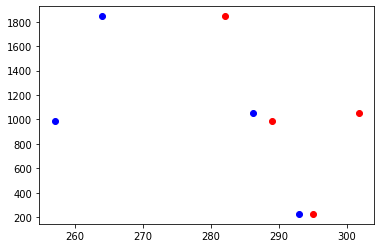

In [79]:
plt.scatter(c.xr, c.z, c = "red")
plt.scatter(c.xl, c.z, c = "blue");

In [119]:
@njit 
def numba_score(combin,eventZ) :
    s = np.zeros(combin.shape[0]) 
    for i, c in enumerate(combin) :
        if ((eventZ - eventZ.mean())**2).sum() == 0 : # dice che se no ci sono delle divisioni per zero anche se non riesco a riprodurle a mano... assurdo
            s[i] = 0 #np.nan
        else :
            slope = ((eventZ - eventZ.mean())*(c - c.mean())).sum() / ((eventZ - eventZ.mean())**2).sum()
            intercept = c.mean() - slope*eventZ.mean() # cfr https://en.wikipedia.org/wiki/Simple_linear_regression con x e y scambiati

            s[i] = np.linalg.norm(c - (slope*eventZ+intercept))
    return s

def solve_ambiguity(event):
    combin = np.array(list(product(*event.loc[:, ['xr','xl']].to_numpy())))
    s = numba_score(combin,event.z.to_numpy())
    event['xb'] = combin[s.argmin()]
    return event

In [87]:
# df2 = df2.reset_index().groupby(["ORBIT_CNT","EVENT"], group_keys=False).apply(solve_ambiguity2) #reset_index() is needed to make this work
# df2 = df2.set_index(["ORBIT_CNT","EVENT"])
# df2
c = c.groupby('orbit').apply(solve_ambiguity)
c

,orbit,chamber,layer,center,dt,xr,xl,z,xb
6683,1118948,3,1,14,18.500000,294.995300,293.004700,226.3,293.004700
6689,1118948,3,4,13,168.233333,282.050953,263.949047,1845.8,282.050953
6692,1118948,3,3,14,145.300000,301.817140,286.182860,1055.1,286.182860
6695,1118948,3,2,13,297.033333,288.980393,257.019607,990.3,288.980393


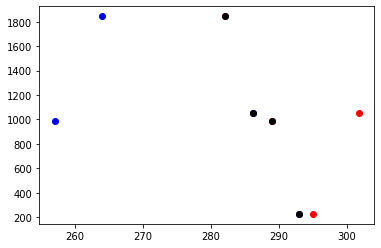

In [94]:
plt.scatter(c.xr, c.z, c = "red")
plt.scatter(c.xl, c.z, c = "blue")
plt.scatter(c.xb, c.z, c = "black");

In [120]:
df5 = df4.copy()
df5 = df5.groupby(['orbit', 'chamber']).apply(solve_ambiguity)
df5

,orbit,chamber,layer,center,dt,xr,xl,z,xb
6683,1118948,3,1,14,18.500000,294.995300,293.004700,226.3,293.004700
6687,1118948,1,1,22,119.733333,468.441653,455.558347,226.3,455.558347
6688,1118948,2,1,24,94.533333,509.085893,498.914107,226.3,509.085893
6689,1118948,3,4,13,168.233333,282.050953,263.949047,1845.8,282.050953
6691,1118948,2,4,23,94.900000,488.105620,477.894380,1845.8,477.894380
...,...,...,...,...,...,...,...,...,...
1304049,5773565,2,2,21,349.933333,459.826413,422.173587,990.3,422.173587
1304050,5773565,2,4,19,376.966667,419.280807,378.719193,1845.8,419.280807
1304051,5773565,2,3,20,523.200000,448.148160,391.851840,1055.1,448.148160
1304056,5773565,1,4,29,173.633333,618.341473,599.658527,1845.8,599.658527


In [103]:
# for index, subframe in tqdm(df4.groupby(['orbit', 'chamber'])) :
#    display(solve_ambiguity(subframe))

  0%|          | 0/937 [00:00<?, ?it/s]

,orbit,chamber,layer,center,dt,xr,xl,z,xb
6687,1118948,1,1,22,119.733333,468.441653,455.558347,226.3,455.558347
6700,1118948,1,2,21,328.700000,458.684060,423.315940,990.3,458.684060
6701,1118948,1,4,23,344.066667,501.510787,464.489213,1845.8,464.489213


,orbit,chamber,layer,center,dt,xr,xl,z,xb
6688,1118948,2,1,24,94.533333,509.085893,498.914107,226.3,509.085893
6691,1118948,2,4,23,94.900000,488.105620,477.894380,1845.8,477.894380
6694,1118948,2,3,24,243.833333,517.118233,490.881767,1055.1,490.881767
6708,1118948,2,2,23,246.400000,496.256320,469.743680,990.3,496.256320


,orbit,chamber,layer,center,dt,xr,xl,z,xb
6683,1118948,3,1,14,18.500000,294.995300,293.004700,226.3,293.004700
6689,1118948,3,4,13,168.233333,282.050953,263.949047,1845.8,282.050953
6692,1118948,3,3,14,145.300000,301.817140,286.182860,1055.1,286.182860
6695,1118948,3,2,13,297.033333,288.980393,257.019607,990.3,288.980393


,orbit,chamber,layer,center,dt,xr,xl,z,xb
7886,1123056,0,3,22,47.566667,464.559087,459.440913,1055.1,459.440913
7887,1123056,0,1,22,95.766667,467.152247,456.847753,226.3,456.847753
7890,1123056,0,2,21,374.100000,461.126580,420.873420,990.3,461.126580
7904,1123056,0,4,23,394.666667,504.233067,461.766933,1845.8,461.766933


,orbit,chamber,layer,center,dt,xr,xl,z,xb
7885,1123056,1,3,24,68.200000,507.669160,500.330840,1055.1,500.330840
7888,1123056,1,2,23,249.100000,496.401580,469.598420,990.3,496.401580
7889,1123056,1,1,24,288.466667,519.519507,488.480493,226.3,488.480493
7905,1123056,1,4,25,349.266667,543.790547,506.209453,1845.8,506.209453


,orbit,chamber,layer,center,dt,xr,xl,z,xb
7882,1123056,2,4,25,23.633333,526.271473,523.728527,1845.8,523.728527
7900,1123056,2,2,25,71.800000,528.862840,521.137160,990.3,521.137160
7901,1123056,2,1,24,345.766667,522.602247,485.397753,226.3,522.602247
7902,1123056,2,3,24,394.233333,525.209753,482.790247,1055.1,525.209753


,orbit,chamber,layer,center,dt,xr,xl,z,xb
8225,1124284,1,2,25,102.233333,530.500153,519.499847,990.3,519.499847
8226,1124284,1,3,24,220.500000,515.862900,492.137100,1055.1,515.862900
8227,1124284,1,4,25,278.233333,539.968953,510.031047,1845.8,510.031047
8236,1124284,1,1,24,399.933333,525.516413,482.483587,226.3,525.516413


,orbit,chamber,layer,center,dt,xr,xl,z,xb
8216,1124284,2,3,20,101.533333,425.462493,414.537507,1055.1,425.462493
8219,1124284,2,1,20,123.066667,426.620987,413.379013,226.3,426.620987
8222,1124284,2,4,21,328.433333,458.669713,423.330287,1845.8,423.330287
8240,1124284,2,2,21,304.533333,457.383893,424.616107,990.3,424.616107


,orbit,chamber,layer,center,dt,xr,xl,z,xb
8215,1124284,3,3,18,26.133333,379.405973,376.594027,1055.1,379.405973
8217,1124284,3,1,18,69.933333,381.762413,374.237587,226.3,381.762413
8220,1124284,3,4,19,377.400000,419.304120,378.695880,1845.8,378.695880
8223,1124284,3,2,19,376.600000,419.261080,378.738920,990.3,378.738920


,orbit,chamber,layer,center,dt,xr,xl,z,xb
9082,1126947,1,1,22,244.933333,475.177413,448.822587,226.3,475.177413
9083,1126947,1,2,23,270.766667,497.567247,468.432753,990.3,468.432753
9092,1126947,1,4,21,343.233333,459.465953,422.534047,1845.8,459.465953


,orbit,chamber,layer,center,dt,xr,xl,z,xb
9075,1126947,2,2,21,199.733333,451.745653,430.254347,990.3,451.745653
9077,1126947,2,3,22,171.966667,471.251807,452.748193,1055.1,452.748193
9079,1126947,2,4,21,247.600000,454.320880,427.679120,1845.8,454.320880
9089,1126947,2,1,22,238.266667,474.818747,449.181253,226.3,449.181253


,orbit,chamber,layer,center,dt,xr,xl,z,xb
9073,1126947,3,4,25,16.566667,525.891287,524.108713,1845.8,524.108713
9076,1126947,3,2,25,73.066667,528.930987,521.069013,990.3,521.069013
9078,1126947,3,3,24,367.800000,523.787640,484.212360,1055.1,523.787640
9090,1126947,3,1,24,320.566667,521.246487,486.753513,226.3,521.246487


,orbit,chamber,layer,center,dt,xr,xl,z,xb
10039,1130581,1,4,23,-98.233333,477.715047,488.284953,1845.8,477.715047
10052,1130581,1,2,23,30.133333,484.621173,481.378827,990.3,484.621173
10053,1130581,1,1,24,73.066667,507.930987,500.069013,226.3,500.069013
10054,1130581,1,3,24,227.566667,516.243087,491.756913,1055.1,491.756913


  1%|▏         | 13/937 [00:00<00:07, 120.37it/s]

,orbit,chamber,layer,center,dt,xr,xl,z,xb
10041,1130581,2,3,24,22.566667,505.214087,502.785913,1055.1,502.785913
10043,1130581,2,2,23,107.633333,488.790673,477.209327,990.3,488.790673
10046,1130581,2,1,24,120.966667,510.508007,497.491993,226.3,497.491993
10064,1130581,2,4,23,277.166667,497.911567,468.088433,1845.8,497.911567


,orbit,chamber,layer,center,dt,xr,xl,z,xb
10042,1130581,3,2,31,34.100000,652.834580,649.165420,990.3,652.834580
10045,1130581,3,4,31,153.833333,659.276233,642.723767,1845.8,642.723767
10047,1130581,3,1,32,169.933333,681.142413,662.857587,226.3,662.857587


,orbit,chamber,layer,center,dt,xr,xl,z,xb
11341,1135298,0,2,11,21.833333,232.174633,229.825367,990.3,232.174633
11344,1135298,0,4,11,169.900000,240.140620,221.859380,1845.8,240.140620
11346,1135298,0,3,12,293.000000,267.763400,236.236600,1055.1,236.236600
11357,1135298,0,1,10,317.866667,227.101227,192.898773,226.3,227.101227


,orbit,chamber,layer,center,dt,xr,xl,z,xb
11342,1135298,1,3,28,19.666667,589.058067,586.941933,1055.1,586.941933
11343,1135298,1,4,27,42.400000,569.281120,564.718880,1845.8,569.281120
11345,1135298,1,2,27,48.900000,569.630820,564.369180,990.3,569.630820
11356,1135298,1,1,28,363.900000,607.577820,568.422180,226.3,568.422180


,orbit,chamber,layer,center,dt,xr,xl,z,xb
11338,1135298,2,1,24,18.9,505.01682,502.98318,226.3,502.98318
11352,1135298,2,3,24,137.6,511.40288,496.59712,1055.1,511.40288
11353,1135298,2,4,25,170.1,534.15138,515.84862,1845.8,515.84862
11354,1135298,2,2,25,318.7,542.14606,507.85394,990.3,507.85394


,orbit,chamber,layer,center,dt,xr,xl,z,xb
15677,1150842,1,4,27,70.300000,570.782140,563.217860,1845.8,570.782140
15678,1150842,1,1,28,165.966667,596.929007,579.070993,226.3,579.070993
15679,1150842,1,4,29,70.300000,612.782140,605.217860,1845.8,605.217860
15688,1150842,1,2,27,201.600000,577.846080,556.153920,990.3,577.846080
15689,1150842,1,3,28,270.500000,602.552900,573.447100,1055.1,573.447100
15690,1150842,1,3,28,617.166667,621.203567,554.796433,1055.1,554.796433


,orbit,chamber,layer,center,dt,xr,xl,z,xb
15673,1150842,2,3,22,41.733333,464.245253,459.754747,1055.1,459.754747
15675,1150842,2,1,22,221.600000,473.922080,450.077920,226.3,450.077920
15704,1150842,2,2,21,278.066667,455.959987,426.040013,990.3,455.959987
15705,1150842,2,4,23,318.633333,500.142473,465.857527,1845.8,465.857527


,orbit,chamber,layer,center,dt,xr,xl,z,xb
18847,1161788,1,2,21,51.400000,443.765320,438.234680,990.3,438.234680
18860,1161788,1,1,22,218.900000,473.776820,450.223180,226.3,450.223180
18861,1161788,1,3,20,273.833333,434.732233,405.267767,1055.1,434.732233
18862,1161788,1,4,21,277.800000,455.945640,426.054360,1845.8,426.054360


,orbit,chamber,layer,center,dt,xr,xl,z,xb
18848,1161788,2,4,23,96.766667,488.206047,477.793953,1845.8,477.793953
18850,1161788,2,1,22,143.700000,469.731060,454.268940,226.3,454.268940
18851,1161788,2,2,21,202.233333,451.880153,430.119847,990.3,451.880153
18856,1161788,2,2,23,205.766667,494.070247,471.929753,990.3,471.929753
18857,1161788,2,3,22,249.666667,475.432067,448.567933,1055.1,475.432067


,orbit,chamber,layer,center,dt,xr,xl,z,xb
18858,1161788,3,4,31,-13365.266667,-68.051347,1370.051347,1845.8,1370.051347
18859,1161788,3,1,32,-13511.466667,-54.916907,1398.916907,226.3,1398.916907
18864,1161788,3,2,31,-13356.466667,-67.577907,1369.577907,990.3,1369.577907
18865,1161788,3,3,32,-13240.300000,-40.328140,1384.328140,1055.1,1384.328140


,orbit,chamber,layer,center,dt,xr,xl,z,xb
19415,1163664,1,3,24,15.933333,504.857213,503.142787,1055.1,504.857213
19428,1163664,1,1,24,92.033333,508.951393,499.048607,226.3,508.951393
19429,1163664,1,4,23,316.766667,500.042047,465.957953,1845.8,500.042047
19430,1163664,1,2,25,368.900000,544.846820,505.153180,990.3,505.153180


,orbit,chamber,layer,center,dt,xr,xl,z,xb
19416,1163664,2,3,20,138.833333,427.469233,412.530767,1055.1,412.530767
19419,1163664,2,1,20,138.900000,427.472820,412.527180,226.3,412.527180
19424,1163664,2,4,19,270.933333,413.576213,384.423787,1845.8,413.576213
19425,1163664,2,2,19,246.833333,412.279633,385.720367,990.3,412.279633


,orbit,chamber,layer,center,dt,xr,xl,z,xb
19417,1163664,3,1,20,165.366667,428.896727,411.103273,226.3,411.103273
19418,1163664,3,2,19,223.700000,411.035060,386.964940,990.3,411.035060


  3%|▎         | 26/937 [00:00<00:07, 123.05it/s]

,orbit,chamber,layer,center,dt,xr,xl,z,xb
22602,1175583,1,4,23,18.033333,483.970193,482.029807,1845.8,483.970193
22603,1175583,1,1,24,142.233333,511.652153,496.347847,226.3,496.347847
22624,1175583,1,2,23,198.066667,493.655987,472.344013,990.3,493.655987
22625,1175583,1,3,24,292.166667,519.718567,488.281433,1055.1,488.281433


,orbit,chamber,layer,center,dt,xr,xl,z,xb
22599,1175583,2,3,24,146.333333,511.872733,496.127267,1055.1,511.872733
22605,1175583,2,1,24,122.033333,510.565393,497.434607,226.3,510.565393
22607,1175583,2,4,25,248.033333,538.344193,511.655807,1845.8,511.655807
22613,1175583,2,2,25,273.066667,539.690987,510.309013,990.3,510.309013


,orbit,chamber,layer,center,dt,xr,xl,z,xb
22597,1175583,3,3,24,68.000000,507.658400,500.341600,1055.1,507.658400
22604,1175583,3,1,24,70.566667,507.796487,500.203513,226.3,507.796487
22606,1175583,3,4,25,325.533333,542.513693,507.486307,1845.8,507.486307
22614,1175583,3,2,25,348.066667,543.725987,506.274013,990.3,506.274013


,orbit,chamber,layer,center,dt,xr,xl,z,xb
26931,1190501,1,2,9,-4544.233333,-55.479753,433.479753,990.3,433.479753
26940,1190501,1,1,24,122.433333,510.586913,497.413087,226.3,497.413087
26941,1190501,1,4,23,120.500000,489.482900,476.517100,1845.8,476.517100
26942,1190501,1,3,24,149.666667,512.052067,495.947933,1055.1,495.947933
26943,1190501,1,2,23,374.733333,503.160653,462.839347,990.3,462.839347


,orbit,chamber,layer,center,dt,xr,xl,z,xb
26933,1190501,2,2,21,28.066667,442.509987,439.490013,990.3,439.490013
26936,1190501,2,4,21,175.500000,450.441900,431.558100,1845.8,431.558100
26938,1190501,2,3,20,345.066667,438.564587,401.435413,1055.1,438.564587
26956,1190501,2,1,22,290.566667,477.632487,446.367513,226.3,446.367513


,orbit,chamber,layer,center,dt,xr,xl,z,xb
26934,1190501,3,2,9,53.266667,191.865747,186.134253,990.3,186.134253
26937,1190501,3,4,9,198.633333,199.686473,178.313527,1845.8,178.313527
26939,1190501,3,1,10,347.233333,228.681153,191.318847,226.3,191.318847
26957,1190501,3,3,8,294.033333,183.818993,152.181007,1055.1,183.818993


,orbit,chamber,layer,center,dt,xr,xl,z,xb
32550,1209695,1,1,24,62.433333,507.358913,500.641087,226.3,507.358913
32551,1209695,1,2,23,150.566667,491.100487,474.899513,990.3,491.100487
32560,1209695,1,4,23,243.633333,496.107473,469.892527,1845.8,469.892527
32561,1209695,1,1,24,513.066667,531.602987,476.397013,226.3,531.602987
32562,1209695,1,4,23,673.633333,519.241473,446.758527,1845.8,446.758527


,orbit,chamber,layer,center,dt,xr,xl,z,xb
32553,1209695,2,2,21,148.266667,448.976747,433.023253,990.3,433.023253
32554,1209695,2,3,20,217.366667,431.694327,408.305673,1055.1,431.694327
32555,1209695,2,1,20,344.100000,438.512580,401.487420,226.3,438.512580
32568,1209695,2,4,21,273.000000,455.687400,426.312600,1845.8,426.312600


,orbit,chamber,layer,center,dt,xr,xl,z,xb
41647,1245187,1,1,28,119.733333,594.441653,581.558347,226.3,581.558347
41660,1245187,1,4,27,97.166667,572.227567,561.772433,1845.8,561.772433
41661,1245187,1,2,27,177.633333,576.556673,557.443327,990.3,576.556673
41662,1245187,1,3,28,367.566667,607.775087,568.224913,1055.1,568.224913


,orbit,chamber,layer,center,dt,xr,xl,z,xb
41643,1245187,2,1,24,21.400000,505.151320,502.848680,226.3,505.151320
41649,1245187,2,3,24,144.033333,511.748993,496.251007,1055.1,511.748993
41650,1245187,2,4,25,219.666667,536.818067,513.181933,1845.8,513.181933
41651,1245187,2,2,25,329.733333,542.739653,507.260347,990.3,507.260347


  4%|▍         | 36/937 [00:00<00:07, 116.93it/s]


ZeroDivisionError: division by zero

In [114]:
ve = df4.loc[df4.orbit == df4.orbit.unique()[35]].sort_values('chamber').z.to_numpy().reshape((-1,4))
ve

array([[ 226.3, 1055.1, 1845.8,  990.3],
       [ 226.3,  990.3, 1055.1, 1845.8],
       [1055.1,  226.3, 1845.8,  990.3]])

In [116]:
for i in range(3) :
    print(((ve[i] - ve[i].mean())**2).sum())

1313667.8675
1313667.8675
1313667.8675


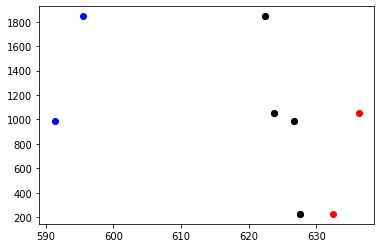

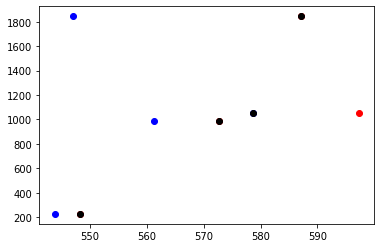

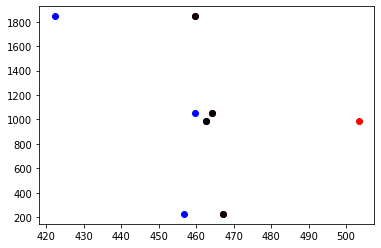

In [125]:
vxr = df5.loc[df5.orbit == df5.orbit.unique()[35]].sort_values('chamber').xr.to_numpy().reshape((-1, 4))
vxl = df5.loc[df5.orbit == df5.orbit.unique()[35]].sort_values('chamber').xl.to_numpy().reshape((-1, 4))
vxb = df5.loc[df5.orbit == df5.orbit.unique()[35]].sort_values('chamber').xb.to_numpy().reshape((-1, 4))
vz = df5.loc[df5.orbit == df5.orbit.unique()[35]].sort_values('chamber').z.to_numpy().reshape((-1, 4))
for i in range(3) :
    fig, ax = plt.subplots()
    ax.scatter(vxl[i], vz[i], c = 'blue')
    ax.scatter(vxr[i], vz[i], c = 'red')
    ax.scatter(vxb[i], vz[i], c = 'black')

In [ ]:
# si può fare una funzione "fit" che calcoli pendenza e intercetta (njit); questa stessa può essere usata sia per il calcolo del chi quadro che riciclata per il fit globale